In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

# 0. Import and path setup

In [13]:
import sys, os

#path = "drive/MyDrive/projet_digitale/Spectrogram_Reconstruction_Model"

#os.chdir(path)

!ls

sys.path.append(os.getcwd() + os.sep + 'src/')

classifier.py			models		   sound_id.pickle
data				projection.pickle  src
latent_space_exploration.ipynb	results		   tsne_df.pickle


In [4]:
import sys, os
sys.path.append("../src")
sys.path.append("../src_charly")

import numpy as np
import glob2
import joblib
import pathlib
from scipy.io.wavfile import write as write_waveform
from collections import OrderedDict
import matplotlib.pyplot as plt
#import seaborn as sns
import pickle
import pandas as pd

import torch
import torch.nn.functional as F
import torch.nn as nn

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from spectrogram_stream import SpectrogramStream
from autoencoders import ConvolutionalAutoencoder
from encoders import ConvolutionalEncoder
from bottlenecks import ConvolutionalBottleneck
from reconstructors import ConvolutionalDecoder
from visualization import spectrogram_to_waveform, compute_reconstruction_plot


# 1. Load the pretrained encoder

In [5]:
def find_last_checkpoint(models_path, experiment_name):
    checkpoint_path_pattern = os.path.join(models_path, experiment_name + '_checkpoint_*.pth')
    print(f'Looking for checkpoints at {checkpoint_path_pattern}')
    checkpoints = glob2.glob(checkpoint_path_pattern)
    checkpoints = sorted(checkpoints, key=lambda x: int(os.path.splitext(x)[0].split('_')[-1]))
    print(f'Loading checkpoint {checkpoints[-1]}...')
    last_checkpoint = torch.load(checkpoints[-1], map_location=device)
    print(f'Checkpoint {checkpoints[-1]} loaded')
    return last_checkpoint

In [7]:
data_path = '../data/spectrograms'
models_path = '../models'
experiment_name = 'dataset2filtered_b64_baseline_larger_l1'
results_path = os.path.join('results', experiment_name)
frame_step = 46
n_iter = 300
sampling_rate = 16000
n_images = 10

pathlib.Path(results_path).mkdir(parents=True, exist_ok=True)

# Device
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

# Select available device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')


# Build and load model
print('Building model...')
model = ConvolutionalAutoencoder(
    encoder=ConvolutionalEncoder(),
    bottleneck=ConvolutionalBottleneck(),
    reconstructor=ConvolutionalDecoder()
).to(device)

print('Searching last checkpoint...')
checkpoint = find_last_checkpoint(models_path, experiment_name)

print('Loading checkpoint...')
new_state_dict = OrderedDict()
for mod in ['model', 'optimizer']:
    new_state_dict[mod] = {}
    for k, v in checkpoint[mod if mod in checkpoint else mod + '_exception'].items():
        new_state_dict[mod][k.replace('module.', '')] = v
checkpoint = new_state_dict

model.load_state_dict(checkpoint['model'])


Device: cuda:0
Building model...
Searching last checkpoint...
Looking for checkpoints at ../models/dataset2filtered_b64_baseline_larger_l1_checkpoint_*.pth
Loading checkpoint ../models/dataset2filtered_b64_baseline_larger_l1_checkpoint_126633.pth...
Checkpoint ../models/dataset2filtered_b64_baseline_larger_l1_checkpoint_126633.pth loaded
Loading checkpoint...


<All keys matched successfully>

In [8]:
encoder = model.encoder.layers
type(encoder)

torch.nn.modules.container.Sequential

# 2. Encoding of our data in the latent space

In [22]:
!ls ../data/spectrograms/

0014a05b7983f18441b13ce4e4949b6d5d93ffabc11009b3808e9823f0e0ac52d1616f1d029a69581bb57dc83084d9f0edd9761948b4648ecf67d0647bda11e8
0025335d676c57a7103e733abf211b9499406be7687ccd8e5746641df3c037f825f45106bd9048a5f7bfeb9ba7f4ad277821d1b22670303fadc1a7d0030a269b
002cb63172ebb1a9e9865419d7beae44f3d3729c9582f105bf24ba3c9e2caad2d34199e20703a4c84e4be8dd04df3f18fa654e23d8b4ec91a70caccbb266b35f
005805ffffabbba8fa7dc8f6093bc07716b1b7cd2cf36d081c40825cfb1908cdb57eef584bbc52534d4ecf7c218be8f68e6493744e6fe27ddd638731b125f3a3
00961c3f99304bfe6445a697749b7fc925ac53b7048d7fab8e4227e5c54c33b9f2a65ec158683c9ca72191bf17fb2c9f1c7adb0701d4e613c377fcbc47551124
00a9cb17a3893d3035dd4c9069d8b972e4392ab71161fe30605f2f05ccc9e5fe564a25a2c0da8f0cf0b0ca2e8253a59e5df6abeb824cac234873120e96d6e0dc
00b28bae4b304d87af1af6081a4b73c195bba4771fd67d9730cb3a04152fb900834bed46399c4ed1b009f07c7d4a0afa49b24e083f60e3810667fe204a42157e
00b8570683f49c98ec018349ff6636da19395de0d17f3e06606c42484bf3cabc8e12b304e723650b85380dd976ed5a70f

In [26]:
    stream = SpectrogramStream(root_path="../data", batch_size=n_images,test_train_split=1.0, val_train_split=0.0, subsets_to_load=['train'], sr=sampling_rate)


Loading Spectrogram dataset...
Number of samples detected: 39718
Spectrogram dataset initialized.
Building Spectrogram dataloaders...
Building the data splitter...
Building the train data loader...
Train loader size: 3972
Spectrogram dataloaders built successfully


In [28]:
len(stream.train_loader)

3972

In [34]:
 data["sound_id"] + data["sound_id"]

['common_voice_en_20298481_5',
 'common_voice_en_19981303_10',
 'common_voice_en_22297252_3',
 'common_voice_en_21181316_13',
 'common_voice_en_20757720_6',
 'common_voice_en_20150709_8',
 'common_voice_en_20170021_13',
 'common_voice_en_19775787_3',
 'common_voice_en_21366932_0',
 'common_voice_en_19595987_15',
 'common_voice_en_20298481_5',
 'common_voice_en_19981303_10',
 'common_voice_en_22297252_3',
 'common_voice_en_21181316_13',
 'common_voice_en_20757720_6',
 'common_voice_en_20150709_8',
 'common_voice_en_20170021_13',
 'common_voice_en_19775787_3',
 'common_voice_en_21366932_0',
 'common_voice_en_19595987_15']

In [32]:
len(sound_id)

810

In [31]:
len(set(sound_id))

801

In [37]:
# encode our data
encode = True

if encode:
    projection = [] #list of all our arrays
    sound_id = [] # list of the names of our sounds
    exc = False #exception boolean for the iteration over the iterative dataset
    count=0

    # Load dataset
    stream = SpectrogramStream(root_path="../data", batch_size=200,test_train_split=1.0, val_train_split=0.0, subsets_to_load=['train'], sr=sampling_rate)
    for w in range(len(stream.train_loader)) :#get training data (step by step)
      print(count)
      count+=1
      data = next(iter(stream.train_loader))
      #spectrograms = data['sound'].unsqueeze(1).float().to(device)
      sound_id += data['sound_id']

      # encode it into the latent space (encoding.shape = 24 * 11 , the dimension of our latent space)
      #encoding = encoder(spectrograms).cpu().detach().numpy()
      #x = encoding.reshape(10,24,11)
      #for i in range(x.shape[0]):
      #  projection.append(x[i].reshape(24*11))

Loading Spectrogram dataset...
Number of samples detected: 39718
Spectrogram dataset initialized.
Building Spectrogram dataloaders...
Building the data splitter...
Building the train data loader...
Train loader size: 199
Spectrogram dataloaders built successfully
0
1
2


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73ec7f54a8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 382, in select
    events |= EVENT_WRITE
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_utils/sig

3
4


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73b9d939e8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

5
6
7
8
9


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73e62c9240>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 379, in select
    for fd, event in fd_event_list:
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/

10
11
12
13


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73caceb4e0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

14
15
16
17


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73ec7f54a8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

18
19


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73e053ce48>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 381, in select
    if event & ~select.POLLIN:
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_util

20
21
22


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73e08667f0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

23
24


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73e052f208>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 381, in select
    if event & ~select.POLLIN:
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_util

25


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73f7f4b9e8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

26
27
28


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73e053ce48>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 386, in select
    key = self._key_from_fd(fd)
  File "/usr/lib/python3.6/selectors.py", line 285, in _key_from_fd


29
30


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73f7f4b9e8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

31


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73e62c9240>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 381, in select
    if event & ~select.POLLIN:
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_util

32
33
34
35
36


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73b9d939e8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

37


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73b9d937f0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 381, in select
    if event & ~select.POLLIN:
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_util

38


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73e08667f0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 381, in select
    if event & ~select.POLLIN:
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_util

39
40


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73e053ce48>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 381, in select
    if event & ~select.POLLIN:
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_util

41


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73caceb4e0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 379, in select
    for fd, event in fd_event_list:
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/

42
43
44


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73e052f390>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

45
46
47


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73ec7f54a8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

48
49
50


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f744dfd06d8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 386, in select
    key = self._key_from_fd(fd)
  File "/usr/lib/python3.6/selectors.py", line 285, in _key_from_fd


51
52
53


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73b9d937f0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 382, in select
    events |= EVENT_WRITE
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_utils/sig

54


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73f7f4b9e8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

55
56
57
58


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73e053ce48>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

59
60
61
62


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73b9d937f0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 383, in select
    if event & ~select.POLLOUT:
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_uti

63
64


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73e62c9240>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 381, in select
    if event & ~select.POLLIN:
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_util

65


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73e076d908>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

66
67
68
69
70
71
72
73


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73caceb4e0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 386, in select
    key = self._key_from_fd(fd)
  File "/usr/lib/python3.6/selectors.py", line 275, in _key_from_fd


74


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73e052f208>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

75
76


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f744dfd06d8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

77
78


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73caceb4e0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 386, in select
    key = self._key_from_fd(fd)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_uti

79
80


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73ec7f54a8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 383, in select
    if event & ~select.POLLOUT:
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_uti

81
82


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f744dfd06d8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 388, in select
    ready.append((key, events & key.events))
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

83
84


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73ec7f54a8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 383, in select
    if event & ~select.POLLOUT:
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_uti

85
86
87


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73e052f390>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 384, in select
    events |= EVENT_READ
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_utils/sign

88
89
90
91
92


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73e052f390>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 381, in select
    if event & ~select.POLLIN:
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_util

93
94


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73f7f4b9e8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

95
96


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73caceb4e0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 386, in select
    key = self._key_from_fd(fd)
  File "/usr/lib/python3.6/selectors.py", line 275, in _key_from_fd


97


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73e052f390>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 382, in select
    events |= EVENT_WRITE
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_utils/sig

98
99
100


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73ec7f54a8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

101
102
103


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73e62c9240>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

104
105
106
107
108
109
110
111
112


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73e052f390>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

113
114


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73caceb4e0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

115
116
117
118
119


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73caceb4e0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

120
121


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f744dfd06d8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

122
123


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73b9d937f0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

124
125
126


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f744dfd06d8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 386, in select
    key = self._key_from_fd(fd)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_uti

127


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73b9d937f0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

128
129


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73caceb4e0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

130


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73e08667f0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

131
132
133
134
135


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73e08667f0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 381, in select
    if event & ~select.POLLIN:
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_util

136


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73e052f208>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 381, in select
    if event & ~select.POLLIN:
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_util

137
138
139
140


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73e052f208>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

141
142


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73caceb4e0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

143


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73f7f4b9e8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

144
145
146
147
148
149
150


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73e052f390>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

151


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73caceb4e0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

152


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73e62c9240>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

153
154
155
156
157
158
159


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73e08667f0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

160
161
162


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73e053ce48>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 386, in select
    key = self._key_from_fd(fd)
  File "/usr/lib/python3.6/selectors.py", line 285, in _key_from_fd


163
164


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f744dfd06d8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 381, in select
    if event & ~select.POLLIN:
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_util

165
166


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73e62c9240>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

167


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f744dfd06d8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

168
169


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73b9d939e8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

170
171
172
173


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73e053ce48>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 382, in select
    events |= EVENT_WRITE
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_utils/sig

174
175
176
177
178
179
180
181
182
183
184
185


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f744dfd06d8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

186
187


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73ec7f54a8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

188
189
190
191


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73b9d939e8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/local/lib/python3.6/dist-packages/torch/ut

192
193
194
195


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f73b9d939e8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 386, in select
    key = self._key_from_fd(fd)
  File "/usr/lib/python3.6/selectors.py", line 285, in _key_from_fd


196
197
198


In [3]:
#save/load encoded data
save = False
load = True
if save :
  pickle.dump(projection, open("projection.pickle", "wb"))
  pickle.dump(sound_id, open("sound_id.pickle", "wb"))

if load:
  projection = pickle.load(open("projection.pickle", "rb"))
  sound_id = pickle.load(open("sound_id.pickle", "rb"))
    
projection = np.array(projection)

In [4]:
projection.shape

(39720, 264)

# 3. Identify how attributes are separated in subspaces

In [5]:
#load labels file
label_df = pd.read_csv("data/labels.tsv", sep='\t').drop(columns="Unnamed: 0").set_index("sound_id")

## 1. Axis against axis (encoding dimension)

In [8]:
def plot_axis_vs_axis(i=0,j=1, mod="accent"):
    X = pd.DataFrame([projection[:,i], projection[:,j]], index=["x","y"]).transpose()
    X.index = sound_id
    data = pd.merge(label_df, pd.DataFrame(X, index=sound_id, columns=["x","y"]), right_index=True, left_index =True)
    #display(data) # show the merging of tsne dimensions & the labels
    sns.set(rc={'figure.figsize':(15,12)})
    sns.scatterplot(data=data, x="x", y="y", hue=mod, palette="deep", legend="full")

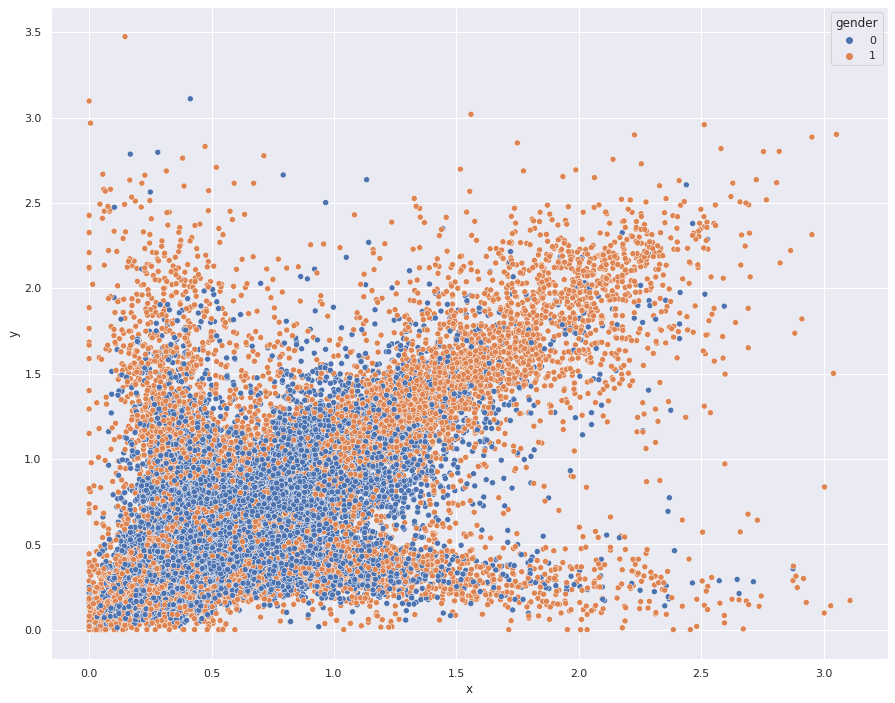

In [10]:
plot_axis_vs_axis(1,2,mod="gender")

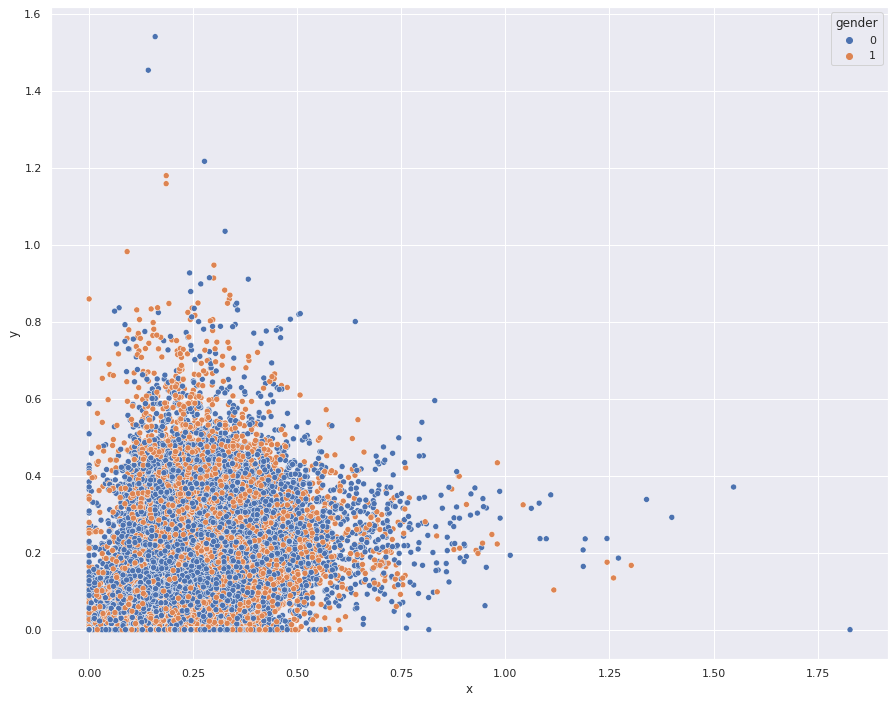

In [33]:
plot_axis_vs_axis(100,200,mod="gender")

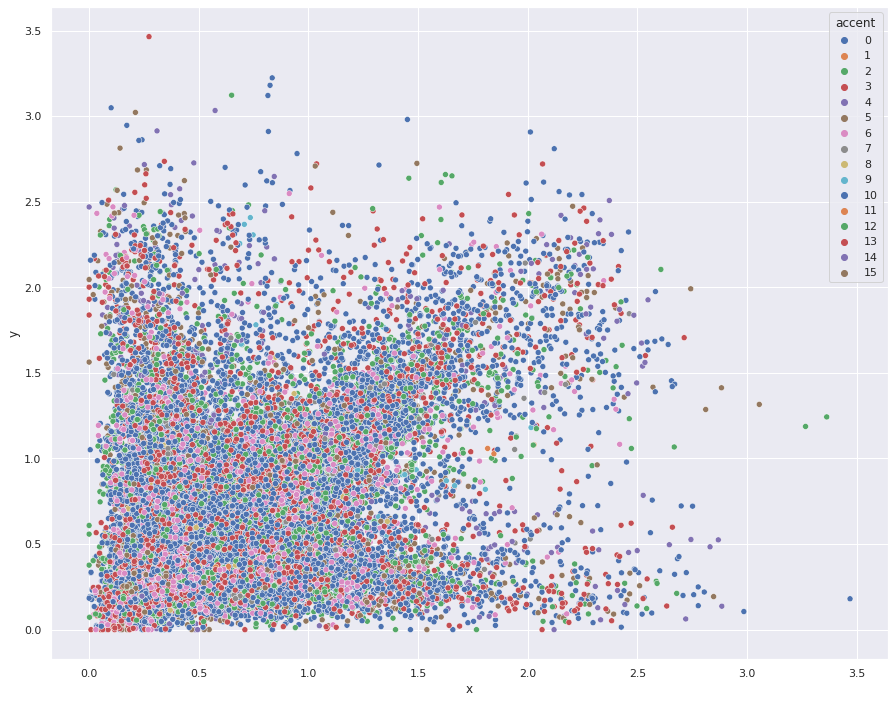

In [45]:
plot_axis_vs_axis(0,3,mod="accent")

In [34]:
# Axis are very similar from what we see on the previous plots
# Try to plot axis vs axis, that are not similar using cosine similarity

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

In [10]:
def simil(x,i,j):
    return cosine_similarity(x[:,i].reshape(1,-1),x[:,j].reshape(1,-1))

In [11]:
p=200
result = np.zeros((p,p))
for i in range(p):
    for j in range(i,p):
        sim = simil(projection,i,j)
        result[i,j] = sim
        result[j,i] =sim

In [59]:
np.argmin(result[2])

189

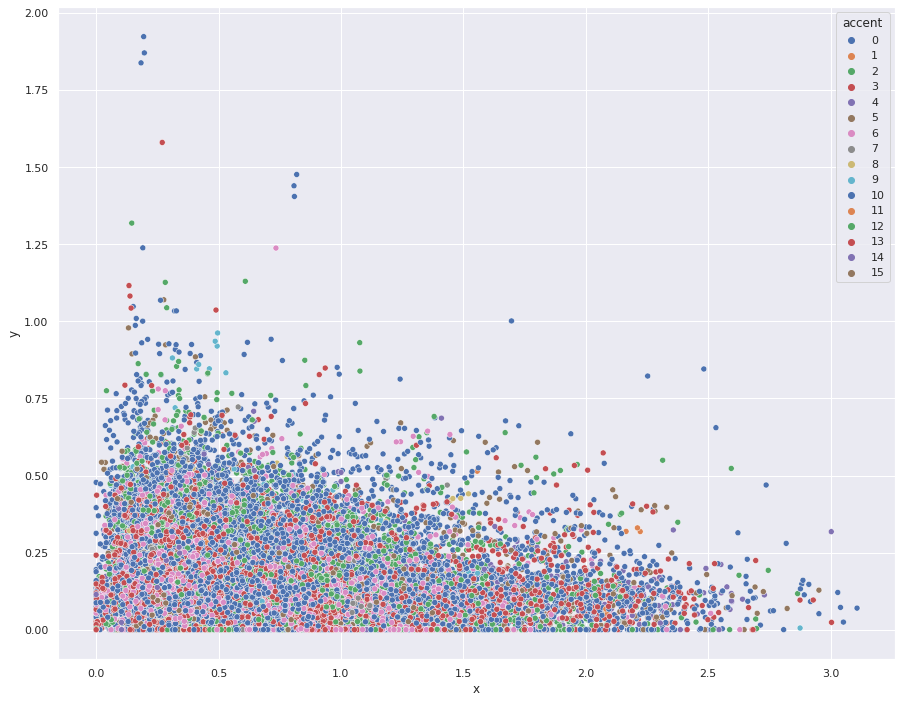

In [15]:
plot_axis_vs_axis(1,np.argmin(result[1]), mod="accent")

## 3. Exploration of ACP axis

In [12]:
#project on a subspace (dimension = ?)
n = projection[0].shape[0]
pca=PCA(n_components=n)
X = pca.fit_transform(X=projection)

Text(0.5, 1.0, 'Cumulative explained variance')

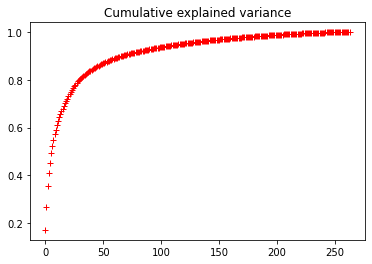

In [13]:
plt.plot([sum(pca.explained_variance_ratio_[:i+1]) for i in range(n)], "r+")
plt.title("Cumulative explained variance")

In [14]:
# join the values along pca axis to the label dataframe
X = X[:,:50] # keep only 100 dimensions of the acp
pca_df = pd.DataFrame(X, columns= ["ax" + str(i) for i in range(X.shape[1])], index=sound_id)
pca_data = pd.merge(label_df, pca_df, right_index=True, left_index =True)
display(pca_data.head(2))

client_id  accent  age  gender  \
common_voice_en_111919_1       1123       0    0       1   
common_voice_en_111919_1       1123       0    0       1   

                                                          original_sentence  \
common_voice_en_111919_1  Two dogs running in a field of dry grass on a ...   
common_voice_en_111919_1  Two dogs running in a field of dry grass on a ...   

                          sentence  intervals  useful_signal_proportions  \
common_voice_en_111919_1       NaN        NaN                   0.866533   
common_voice_en_111919_1       NaN        NaN                   0.866533   

                               ax0       ax1  ...      ax40      ax41  \
common_voice_en_111919_1  0.819452  0.104792  ... -0.219901  0.013398   
common_voice_en_111919_1  0.122234  0.083174  ... -0.263027  0.031016   

                              ax42      ax43      ax44      ax45      ax46  \
common_voice_en_111919_1  0.166494 -0.001526  0.060492  0.153098  0.212472   
common_voice_en_111919_1  0.182424 -0.013817  0.052346  0.226318  0.213685   

                              ax47     ax48      ax49  
common_voice_en_111919_1  0.070068  0.06591  0.063744  
common_voice_en_111919_1  0.073129  0.06515  0.063199  

[2 rows x 58 columns]

In [74]:
def plot_mod_against_axis(i=0,mod="accent"):
  """
  plot the boxplot of values against the axis, for the different values of the chosen modality
  """
  values = list(pca_data[mod].drop_duplicates())
  val_idx = []
  for val in values:
    val_idx.append(np.where(pca_data[mod]==val)[0])

  val_along_ax = pca_data["ax" + str(i)].values
  fig, axes = plt.subplots(1,len(values))

  min_, max_ = min(val_along_ax), max(val_along_ax)
  for j in range(len(values)):
    axes[j].boxplot(val_along_ax[val_idx[j]])
    axes[j].set_title(mod +  " = " + str(values[j]))
    axes[j].set_ylim(min_, max_)


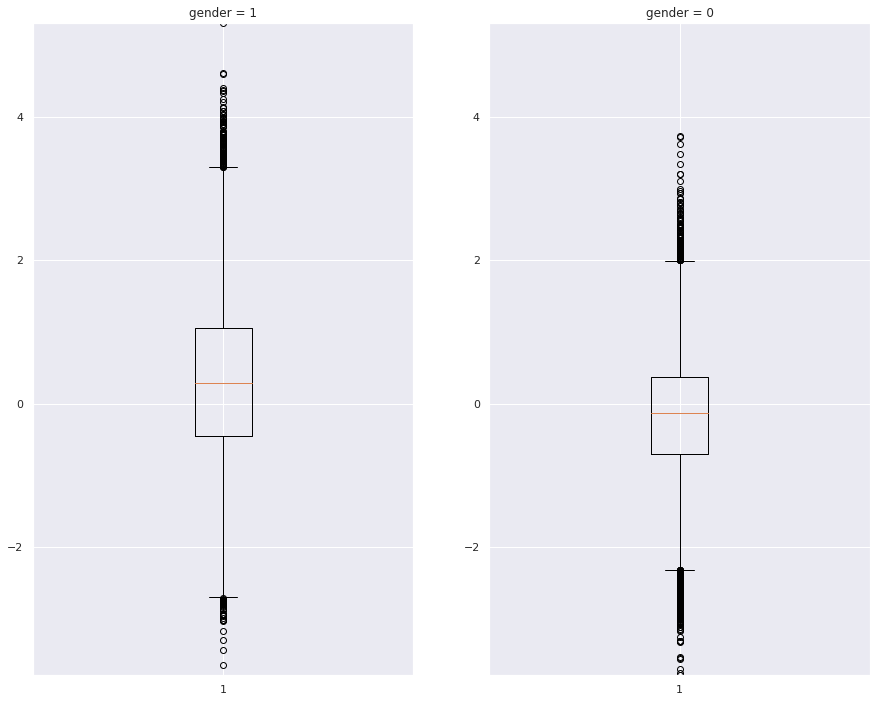

In [75]:
# plot values agains axis vs. modalities
modality = ['accent','age','gender']
mod=modality[2]

plot_mod_against_axis(0,mod) #compute stats (mean, var for every axis/modality ?)

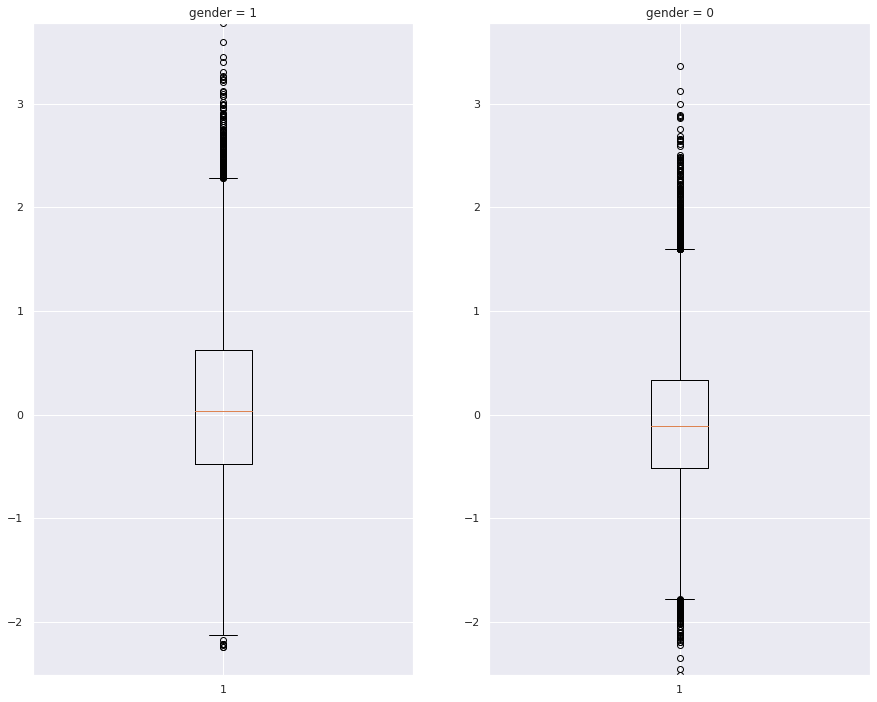

In [187]:
plot_mod_against_axis(1,mod) #compute stats (mean, var for every axis/modality ?)

In [62]:
def plot_axis_vs_axis_ACP(i=0,j=1, mod="age",plot=True):
    if plot:
        sns.set(rc={'figure.figsize':(15,12)})
        sns.scatterplot(data=pca_data, x="ax"+str(i), y="ax"+str(j), hue=mod, palette="deep", legend="full")
    else:
        return data # we return the data along the specified axes

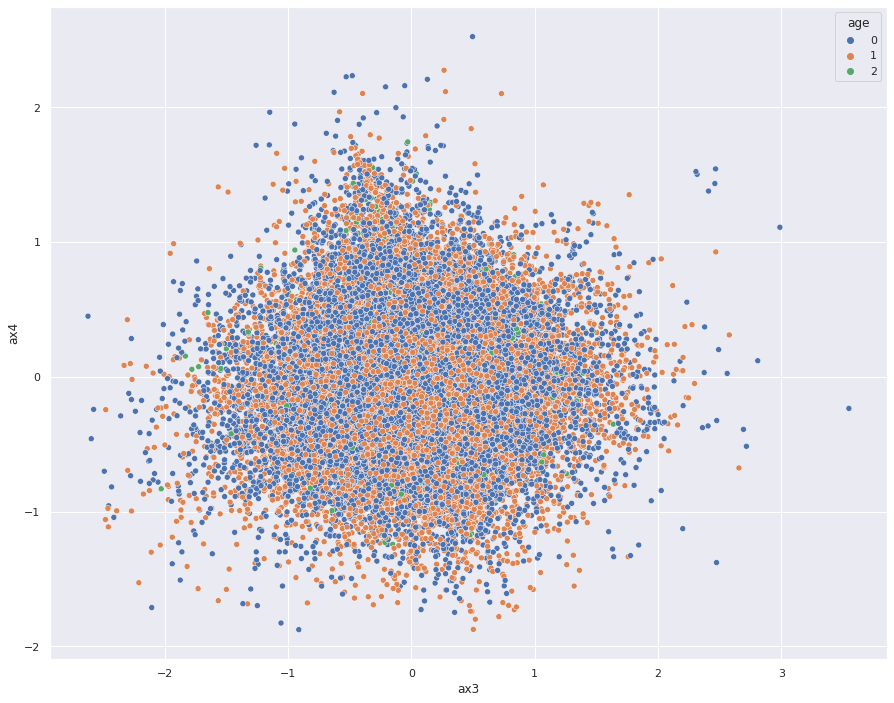

In [63]:
# which axes gives us separabilité between modalities ?
plot_axis_vs_axis_ACP(3,4)

In [64]:
p=50
result = np.zeros((p,p))
for i in range(p):
    for j in range(i,p):
        sim = simil(X,i,j)
        result[i,j] = sim
        result[j,i] =sim

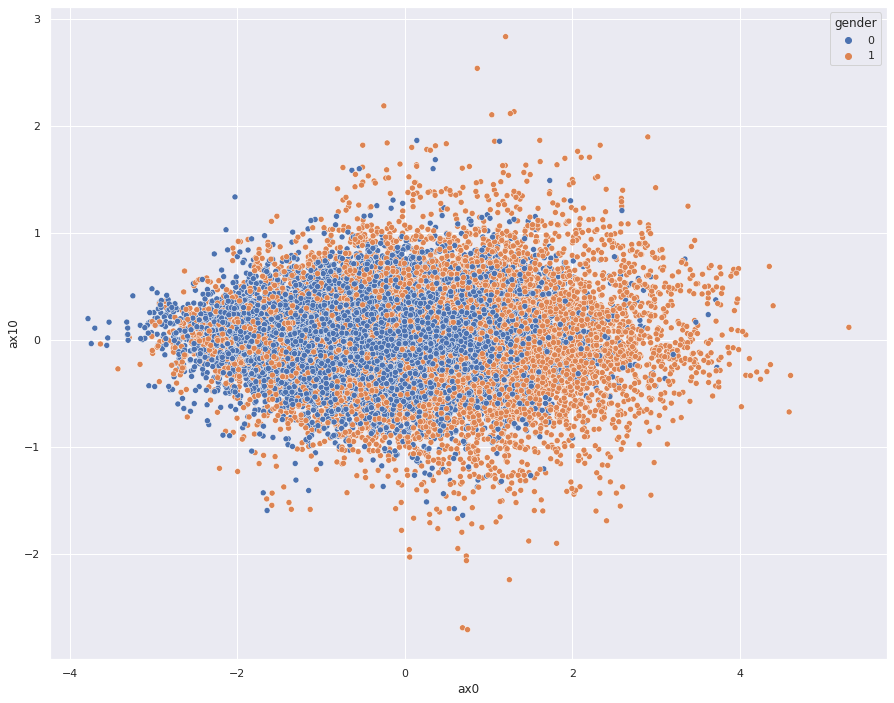

In [76]:
plot_axis_vs_axis_ACP(0,np.argmin(result[0]),mod="gender")  # Ax 0 seems to disciminate the "gender" modalities

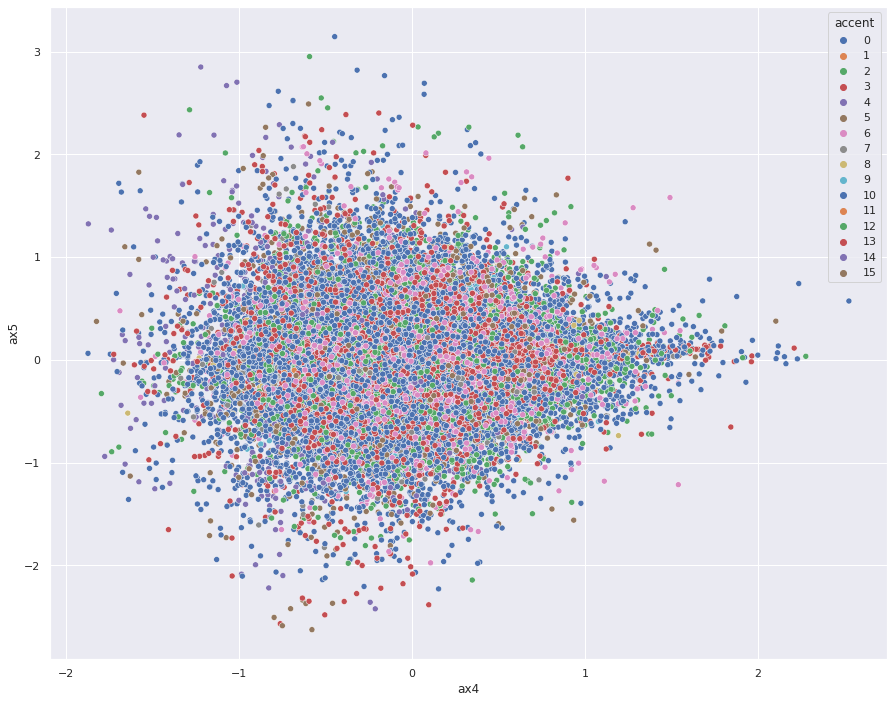

In [82]:
plot_axis_vs_axis_ACP(4,np.argmin(result[4]),mod="accent") 

## 3. Exploration of TSNE dimensions

In [6]:
load = True

if not load:
    #add x,y coordinates, computed with tsne dimension reduction
    model = TSNE()
    X_tsne = model.fit_transform(X[:,:50])
    pickle.dump(X_tsne)
    tsne_df = pd.merge(label_df, pd.DataFrame(X_tsne, columns= ["ax" + str(i) for i in range(X_tsne.shape[1])], index=sound_id), right_index=True, left_index =True)

    pickle.dump(tsne_df, open("tsne_df.pickle", "wb"))
    
else:
    tsne_df = pickle.load(open("tsne_df.pickle","rb"))

In [7]:
tsne_df.head(2)

client_id  accent  age  gender  \
common_voice_en_111919_1       1123       0    0       1   
common_voice_en_111919_1       1123       0    0       1   

                                                          original_sentence  \
common_voice_en_111919_1  Two dogs running in a field of dry grass on a ...   
common_voice_en_111919_1  Two dogs running in a field of dry grass on a ...   

                          sentence  intervals  useful_signal_proportions  \
common_voice_en_111919_1       NaN        NaN                   0.866533   
common_voice_en_111919_1       NaN        NaN                   0.866533   

                                ax0        ax1  
common_voice_en_111919_1 -41.805264  37.829708  
common_voice_en_111919_1 -41.811626  37.842880

<AxesSubplot:xlabel='ax0', ylabel='ax1'>

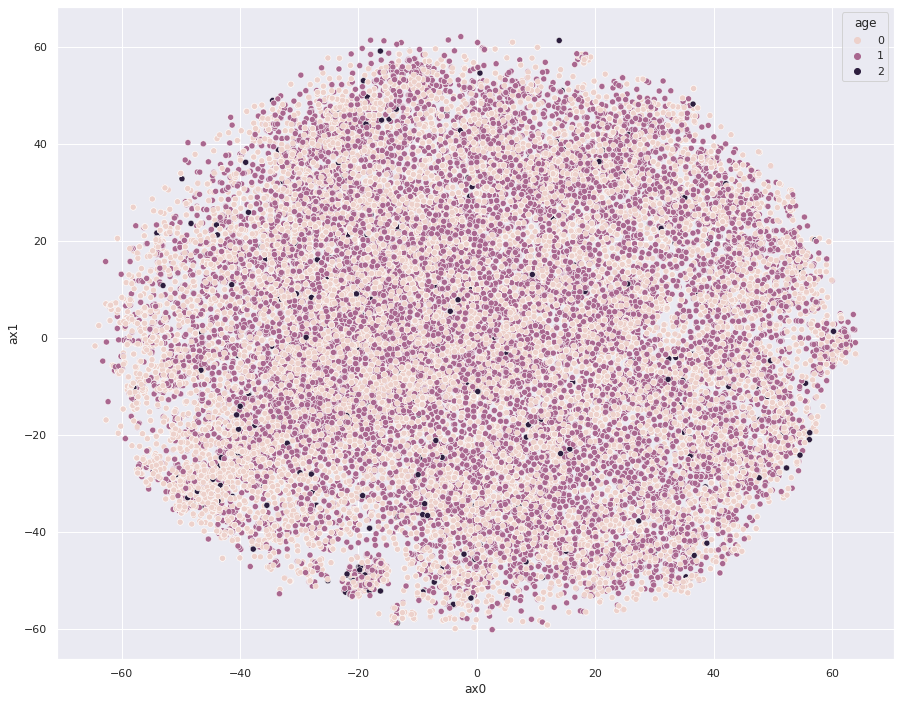

In [98]:
sns.scatterplot(data=tsne_df, x="ax0", y="ax1", hue = "age")

# 4. Classifier on the latent space

In [95]:
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix

In [75]:
# dataset to train classifier on "gender" attribute
X = pd.merge(label_df[['gender']], pd.DataFrame(projection, index=sound_id), right_index=True, left_index =True)
Y = X[['gender']]
X = X.drop(columns="gender")

#Y=Y.values
#X=X.values
#normalize into [0,1]
max_ = X.max().max()
min_ = X.min().min()
X = ((X - min_) /(max_ - min_))

#split train/test datasets
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2)

In [105]:
X_train

0         1         2         3         4    \
common_voice_en_21312690_23  0.250676  0.262940  0.274292  0.227966  0.165303   
common_voice_en_19840643_15  0.181205  0.169582  0.210392  0.196049  0.207286   
common_voice_en_19265270_0   0.157793  0.099155  0.055275  0.066678  0.091336   
common_voice_en_19728495_2   0.288663  0.314725  0.167647  0.204213  0.177312   
common_voice_en_19696496_0   0.252116  0.117652  0.348685  0.425336  0.384351   
...                               ...       ...       ...       ...       ...   
common_voice_en_20990155_6   0.137746  0.389127  0.401700  0.384960  0.534746   
common_voice_en_18712948_3   0.215224  0.225745  0.214631  0.221630  0.216215   
common_voice_en_19389794_19  0.467500  0.438450  0.052930  0.076320  0.128077   
common_voice_en_21693039_6   0.046235  0.040958  0.146300  0.090451  0.153969   
common_voice_en_19396599_9   0.118436  0.073202  0.136271  0.045700  0.074777   

                                  5         6         7         8         9    \
common_voice_en_21312690_23  0.220622  0.229821  0.231482  0.254946  0.230519   
common_voice_en_19840643_15  0.196274  0.125093  0.198853  0.194137  0.196559   
common_voice_en_19265270_0   0.033727  0.064821  0.018359  0.241874  0.034502   
common_voice_en_19728495_2   0.158202  0.172660  0.175552  0.179363  0.117510   
common_voice_en_19696496_0   0.369515  0.350825  0.344603  0.340909  0.329222   
...                               ...       ...       ...       ...       ...   
common_voice_en_20990155_6   0.103241  0.367211  0.449891  0.096603  0.056138   
common_voice_en_18712948_3   0.224583  0.218703  0.229463  0.235859  0.232252   
common_voice_en_19389794_19  0.364268  0.513677  0.087876  0.153326  0.101107   
common_voice_en_21693039_6   0.251418  0.354449  0.244391  0.134244  0.099602   
common_voice_en_19396599_9   0.050150  0.054455  0.052133  0.075540  0.155601   

                             ...  254  255  256  257  258  259  260  261  262  \
common_voice_en_21312690_23  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
common_voice_en_19840643_15  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
common_voice_en_19265270_0   ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
common_voice_en_19728495_2   ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
common_voice_en_19696496_0   ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...                          ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
common_voice_en_20990155_6   ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
common_voice_en_18712948_3   ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
common_voice_en_19389794_19  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
common_voice_en_21693039_6   ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
common_voice_en_19396599_9   ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                             263  
common_voice_en_21312690_23  0.0  
common_voice_en_19840643_15  0.0  
common_voice_en_19265270_0   0.0  
common_voice_en_19728495_2   0.0  
common_voice_en_19696496_0   0.0  
...                          ...  
common_voice_en_20990155_6   0.0  
common_voice_en_18712948_3   0.0  
common_voice_en_19389794_19  0.0  
common_voice_en_21693039_6   0.0  
common_voice_en_19396599_9   0.0  

[31776 rows x 264 columns]

In [83]:
clf = LogisticRegression(max_iter=10000)

In [84]:
clf.fit(X_train, Y_train)

/home/klegoff/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LogisticRegression(max_iter=10000)

[Text(0.5, 84.5, 'Predicted class'), Text(111.5, 0.5, 'Real class')]

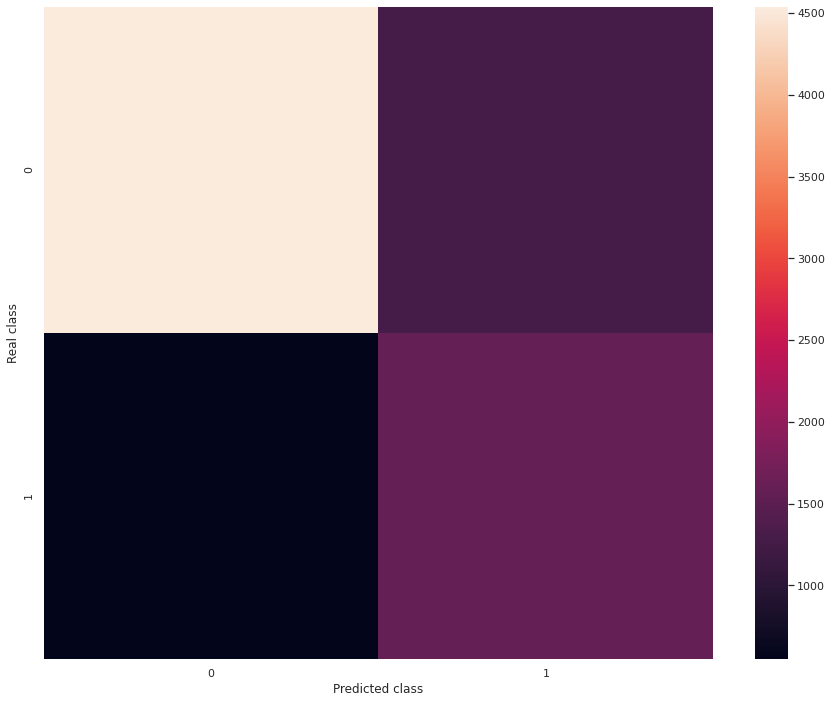

In [101]:
#Evaluate perf on new data
Y_pred = pd.DataFrame(clf.predict(X_test), index=Y_test.index)
cm = confusion_matrix(Y_pred, Y_test)
ax = sns.heatmap(cm)
ax.set(xlabel='Predicted gender', ylabel='Real gender')

#

In [102]:
cm

array([[4538, 1273],
       [ 548, 1585]])

In [104]:
Y_test.index

Index(['common_voice_en_20882122_0', 'common_voice_en_21101415_3',
       'common_voice_en_20275822_2', 'common_voice_en_22292362_25',
       'common_voice_en_19422828_1', 'common_voice_en_19410703_4',
       'common_voice_en_18981051_20', 'common_voice_en_22330018_3',
       'common_voice_en_19776424_5', 'common_voice_en_21836205_10',
       ...
       'common_voice_en_19511034_11', 'common_voice_en_18750120_11',
       'common_voice_en_18708667_7', 'common_voice_en_21269570_3',
       'common_voice_en_22179329_7', 'common_voice_en_22251192_3',
       'common_voice_en_19948907_16', 'common_voice_en_19795403_1',
       'common_voice_en_19201606_6', 'common_voice_en_22319606_7'],
      dtype='object', length=7944)

# 5. Mean vector of each modalities, over 2D data (TSNE)

In [16]:
tsne_df

client_id  accent  age  gender  \
common_voice_en_111919_1       1123       0    0       1   
common_voice_en_111919_1       1123       0    0       1   
common_voice_en_111919_1       1123       0    0       1   
common_voice_en_111919_1       1123       0    0       1   
common_voice_en_111921_1       1123       0    0       1   
...                             ...     ...  ...     ...   
common_voice_en_97574_4         147       5    1       1   
common_voice_en_97574_4         147       5    1       1   
common_voice_en_97582_4         147       5    1       1   
common_voice_en_97582_4         147       5    1       1   
common_voice_en_97584_4         147       5    1       1   

                                                          original_sentence  \
common_voice_en_111919_1  Two dogs running in a field of dry grass on a ...   
common_voice_en_111919_1  Two dogs running in a field of dry grass on a ...   
common_voice_en_111919_1  Two dogs running in a field of dry grass on a ...   
common_voice_en_111919_1  Two dogs running in a field of dry grass on a ...   
common_voice_en_111921_1  Outdoors in the daytime a person with a ponyta...   
...                                                                     ...   
common_voice_en_97574_4          A woman is sitting in a room and painting.   
common_voice_en_97574_4          A woman is sitting in a room and painting.   
common_voice_en_97582_4              A boy blowing bubbles into the camera.   
common_voice_en_97582_4              A boy blowing bubbles into the camera.   
common_voice_en_97584_4   Soap bubbles are blown in a square where peopl...   

                          sentence  intervals  useful_signal_proportions  \
common_voice_en_111919_1       NaN        NaN                   0.866533   
common_voice_en_111919_1       NaN        NaN                   0.866533   
common_voice_en_111919_1       NaN        NaN                   0.866533   
common_voice_en_111919_1       NaN        NaN                   0.866533   
common_voice_en_111921_1       NaN        NaN                   0.791052   
...                            ...        ...                        ...   
common_voice_en_97574_4        NaN        NaN                   0.985754   
common_voice_en_97574_4        NaN        NaN                   0.985754   
common_voice_en_97582_4        NaN        NaN                   0.676331   
common_voice_en_97582_4        NaN        NaN                   0.676331   
common_voice_en_97584_4        NaN        NaN                   0.986003   

                                ax0        ax1  
common_voice_en_111919_1 -41.805264  37.829708  
common_voice_en_111919_1 -41.811626  37.842880  
common_voice_en_111919_1 -41.808056  37.832317  
common_voice_en_111919_1 -41.811043  37.836880  
common_voice_en_111921_1 -52.493855  30.758774  
...                             ...        ...  
common_voice_en_97574_4  -30.788334  31.338737  
common_voice_en_97574_4  -30.752197  31.342930  
common_voice_en_97582_4   14.691919 -10.886466  
common_voice_en_97582_4   14.691216 -10.885895  
common_voice_en_97584_4  -25.062185 -37.037106  

[39720 rows x 10 columns]

## 1. Gender

In [17]:
# gender mean vector

tsne_df.gender.value_counts() #0 : men, 1 : women

0    25308
1    14412
Name: gender, dtype: int64

In [70]:
var = "gender"

mean0 = [tsne_df.ax0.loc[tsne_df[var] == 0].mean(),tsne_df.ax1.loc[tsne_df[var] == 0].mean()]
var0 = [tsne_df.ax0.loc[tsne_df[var] == 0].var(),tsne_df.ax1.loc[tsne_df[var] == 0].var()]

mean1 = [tsne_df.ax0.loc[tsne_df[var] == 1].mean(),tsne_df.ax1.loc[tsne_df[var] == 1].mean()]
var1 = [tsne_df.ax0.loc[tsne_df[var] == 1].var(),tsne_df.ax1.loc[tsne_df[var] == 1].var()]


print("Men voice mean vector:",mean0, "+/-", var0)
print("Women voice mean vector:",mean1,  "+/-", var1)
# variance >> mean, so mean vector aren't very representative of the individuals
# lower variance for women voices, but we have less example

Men voice mean vector: [4.2314262, 1.8679568] +/- [700.8161, 712.54663]
Women voice mean vector: [-7.4712205, -3.5901515] +/- [1052.3506, 847.85864]


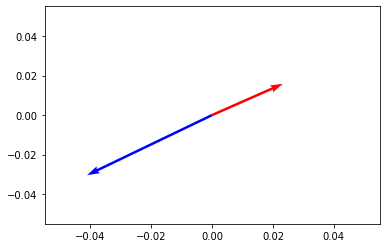

In [71]:
# visual

V = np.array([mean0,mean1])
origin = np.array([[0, 0],[0, 0]]) # origin point

plt.quiver(*origin, V[:,0], V[:,1], color=['r','b'], scale=20)
plt.show()

# vector are colinear and opposed = it forms an axis along which we could modify our data to transform this modality

## 2. Age

In [35]:
# age mean vector

tsne_df.age.value_counts() #0 : , 1 : , 2:
# 2 modality is underepresented

1    21400
0    17683
2      637
Name: age, dtype: int64

In [65]:
var = "age"

mean0 = [tsne_df.ax0.loc[tsne_df[var] == 0].mean(),tsne_df.ax1.loc[tsne_df[var] == 0].mean()]
var0 = [tsne_df.ax0.loc[tsne_df[var] == 0].var(),tsne_df.ax1.loc[tsne_df[var] == 0].var()]

mean1 = [tsne_df.ax0.loc[tsne_df[var] == 1].mean(),tsne_df.ax1.loc[tsne_df[var] == 1].mean()]
var1 = [tsne_df.ax0.loc[tsne_df[var] == 1].var(),tsne_df.ax1.loc[tsne_df[var] == 1].var()]

mean2 = [tsne_df.ax0.loc[tsne_df[var] == 2].mean(),tsne_df.ax1.loc[tsne_df[var] == 2].mean()]
var2 = [tsne_df.ax0.loc[tsne_df[var] == 2].var(),tsne_df.ax1.loc[tsne_df[var] == 2].var()]


print("Age 0 mean vector:",mean0, "+/-", var0)
print("Age 1 mean vector:",mean1, "+/-", var1)
print("Age 2 mean vector:",mean2, "+/-", var2)


Age 0 mean vector: [-2.0073302, -1.6413031] +/- [927.06366, 777.2335]
Age 1 mean vector: [1.7862424, 1.2266225] +/- [797.69507, 755.3502]
Age 2 mean vector: [-5.2060485, -2.6586773] +/- [848.37604, 839.395]


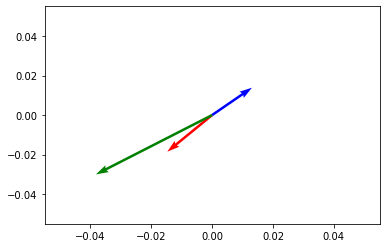

In [68]:
# visual overview

V = np.array([mean0,mean1,mean2])
origin = np.array([[0, 0, 0],[0, 0, 0]]) # origin point

plt.quiver(*origin, V[:,0], V[:,1], color=['r','b','g'], scale=15)
plt.show()

# red and green = age 0 and age 2 go on the oposite direction of blue = age 1
# It's weird because we should expect the change in direction to be monotonous on the age
# Here : age 0 and age 2 are very similar, but should be the most distant values for this modality

## 3. Accent

In [45]:
# accent mean vector

tsne_df.accent.unique() #0 : , 1 : , 2:, (...), 15 :
# 2 modality is underepresented

array([ 0,  5,  2,  9,  6,  3, 13, 12,  7,  4, 15, 14,  8, 10,  1, 11])

In [88]:
var = "accent"

mean = []
var = []

for i in range(0,16):
    
    mean.append([tsne_df.ax0.loc[tsne_df[var] == i].mean(),tsne_df.ax1.loc[tsne_df[var] == i].mean()])
    var.append([tsne_df.ax0.loc[tsne_df[var] == i].var(),tsne_df.ax1.loc[tsne_df[var] == i].var()])
    
for i in range(1,16):
    
    print("Accent ",i, "mean vector:",mean[i], "+/-", var[i])


Accent  1 mean vector: [12.571293, 5.136558] +/- [908.7848, 784.55396]
Accent  2 mean vector: [3.6373003, -2.3643575] +/- [838.6283, 725.29083]
Accent  3 mean vector: [-8.127659, -1.7721144] +/- [822.5521, 777.4237]
Accent  4 mean vector: [-14.056032, 9.579099] +/- [628.9491, 971.0877]
Accent  5 mean vector: [1.1052232, -0.3165816] +/- [936.3479, 768.5914]
Accent  6 mean vector: [1.5630766, 0.017747922] +/- [812.9776, 706.6314]
Accent  7 mean vector: [1.926313, 2.9115744] +/- [758.6703, 758.705]
Accent  8 mean vector: [8.146241, 0.53419954] +/- [653.2973, 768.50037]
Accent  9 mean vector: [8.683348, 0.9295019] +/- [725.4976, 713.56134]
Accent  10 mean vector: [13.214345, -1.8877943] +/- [920.79694, 658.36395]
Accent  11 mean vector: [13.420463, 2.4425583] +/- [989.4698, 567.14294]
Accent  12 mean vector: [2.7405274, 0.64030886] +/- [902.3583, 625.87195]
Accent  13 mean vector: [2.0088975, -2.5897222] +/- [869.1349, 662.8067]
Accent  14 mean vector: [-0.76723737, 7.06025] +/- [942.0098,

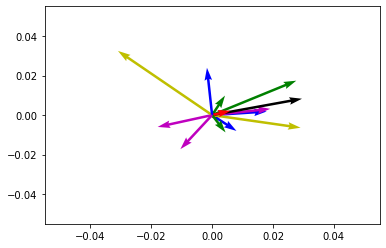

In [93]:
# visual overview

V = np.array(mean)
origin = np.zeros((2,len(V))) # origin point

plt.quiver(*origin, V[:,0], V[:,1], scale=50, color = ["r","g","b","m","y","k"])
plt.show()

# it would be interesting to compare this to geographical data, to see if this is representative of some proximity of the accents

In [ ]:
# What we want to do : add vectorial difference between two mean vectors for a variable, and see if the result is realistic
# data = data + eps * (vect_actual_modality - vect_fake_modality)
# Conclusion : too much variance to get noticeable results
# Can we filter out outliers to reduce variance ?
# We could use data without dimension reduction (here, we have 2D dataset with TSNE reduction vs. 264 in original data (before bottleneck))

In [10]:
type(projection)

numpy.ndarray

In [11]:
projection.shape

(39720, 264)

# 6. Reconstructing signal with autoencoders

In [21]:
model.bottleneck

ConvolutionalBottleneck()

In [23]:
model.reconstructor.layers

Sequential(
  (0): ConvTranspose2d(1, 512, kernel_size=[3, 3], stride=[2, 2], padding=(1, 1))
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): ConvTranspose2d(512, 256, kernel_size=[3, 3], stride=[2, 2], padding=(1, 1))
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): ConvTranspose2d(256, 128, kernel_size=[3, 3], stride=[2, 2], padding=(1, 1))
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): ConvTranspose2d(128, 64, kernel_size=[3, 3], stride=[1, 1], padding=(1, 1))
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): ConvTranspose2d(64, 1, kernel_size=[3, 3], stride=[1, 1], padding=[1, 0])
  (13): Sigmoid()
)

In [25]:
model.forward

<bound method ConvolutionalAutoencoder.forward of ConvolutionalAutoencoder(
  (encoder): ConvolutionalEncoder(
    (layers): Sequential(
      (0): Conv2d(1, 64, kernel_size=[3, 3], stride=[2, 2], padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 128, kernel_size=[3, 3], stride=[2, 2], padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv2d(128, 256, kernel_size=[3, 3], stride=[2, 2], padding=(1, 1))
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): Conv2d(256, 512, kernel_size=[3, 3], stride=[1, 1], padding=(1, 1))
      (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU()
      (12): Conv2d(512, 1, kernel_size=[3, 3], stride=[1, 1], padding=(1, 1))
      (13): BatchNorm2d(1, eps=1

## 1. Stream acces to the dataset

In [27]:
# Load dataset
stream = SpectrogramStream(root_path=data_path, batch_size=n_images,test_train_split=1.0, val_train_split=0.0, subsets_to_load=['train'], sr=sampling_rate)
for i in range(2):
#for w in range(len(stream.train_loader)) :#get training data (step by step)
    data = next(iter(stream.train_loader))

Loading Spectrogram dataset...
Number of samples detected: 39718
Spectrogram dataset initialized.
Building Spectrogram dataloaders...
Building the data splitter...
Building the train data loader...
Train loader size: 3972
Spectrogram dataloaders built successfully


In [29]:
type(data)

dict

In [31]:
data.keys()

dict_keys(['sound', 'sound_id', 'scaler_path'])

In [34]:
data["sound"].shape 
# batch size = 10
# our data is 185 * 83 size

torch.Size([10, 185, 83])

In [35]:
data["sound_id"]

['common_voice_en_18750305_9',
 'common_voice_en_19777729_9',
 'common_voice_en_20068579_0',
 'common_voice_en_21555405_3',
 'common_voice_en_20348053_11',
 'common_voice_en_20905541_6',
 'common_voice_en_18441848_0',
 'common_voice_en_22155854_2',
 'common_voice_en_20835408_2',
 'common_voice_en_20704700_9']

In [45]:
data["sound"][0] # each spectrogramm has value between 0 and 1

tensor([[0.0006, 0.0000, 0.0000,  ..., 0.0042, 0.0000, 0.0013],
        [0.0009, 0.0012, 0.0036,  ..., 0.0071, 0.0083, 0.0177],
        [0.0006, 0.0004, 0.0007,  ..., 0.0235, 0.0345, 0.0259],
        ...,
        [0.0083, 0.0130, 0.0207,  ..., 0.0053, 0.0033, 0.0008],
        [0.0014, 0.0024, 0.0297,  ..., 0.0021, 0.0016, 0.0006],
        [0.0014, 0.0026, 0.0081,  ..., 0.0054, 0.0034, 0.0000]],
       dtype=torch.float64)

In [55]:
model.forward(data["sound"].unsqueeze(1).float().to(device))

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 1.96 GiB total capacity; 1.14 GiB already allocated; 5.88 MiB free; 1.16 GiB reserved in total by PyTorch)

In [49]:
64*3*3

576

In [50]:
185*83

15355